In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
#from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import re
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('ml_gw_car_insurance.csv')
df.head()

,Unnamed: 0,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,...,No,No,No,Yes,No,No,No,Yes,0,0.0
1,1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,...,No,No,No,Yes,No,No,No,Yes,0,0.0
2,2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,...,No,No,No,Yes,No,No,No,Yes,0,0.0
3,3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0.0
4,4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0.0


In [3]:
# Number of car models
df.model.nunique()

11

In [4]:
#Transforming Yes and No values into Booleans
df = df.replace({ "No" : 0 , "Yes" : 1 })

#Removal of policy_id column
df.drop(columns = {"policy_id", 'Unnamed: 0'}, inplace = True)

df.head()

,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,...,0,0,0,1,0,0,0,1,0,0.0
1,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,...,0,0,0,1,0,0,0,1,0,0.0
2,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,...,0,0,0,1,0,0,0,1,0,0.0
3,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,...,1,1,1,1,1,1,1,1,2,0.0
4,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,...,0,1,1,1,0,1,1,1,2,0.0


In [5]:
print(df.age_of_car.max())
print(df.age_of_car.min())

print(df.age_of_policyholder.max())
print(df.age_of_policyholder.min())

1.0
0.0
1.0
0.288461538461538


In [6]:
df.is_claim.value_counts()/df.shape[0] * 100

# Is_Claim is heavily unbalanced -> use class_weight for logistic regression

0.0    56.160975
1.0     3.838001
Name: is_claim, dtype: float64

In [7]:
round(56.160975/3.838001, 0)
# Use this weight for unbalanced classes

15.0

In [8]:
# only considering rows where target variable is not nan
df = df[(df.is_claim == 1) | (df.is_claim == 0)]

# linear correlation
corr = df.corr().abs()
corr_claim = corr['is_claim'].sort_values(ascending=False)
print(f'The variables most correlated with claims are as followed: \n{corr_claim}')

The variables most correlated with claims are as followed: 
is_claim                            1.000000
policy_tenure                       0.078747
age_of_car                          0.028172
age_of_policyholder                 0.022435
population_density                  0.017808
is_adjustable_steering              0.013917
cylinder                            0.013434
is_front_fog_lights                 0.011825
is_brake_assist                     0.010893
is_driver_seat_height_adjustable    0.010686
width                               0.009947
is_parking_sensors                  0.008419
is_day_night_rear_view_mirror       0.007989
displacement                        0.007678
is_speed_alert                      0.007307
is_ecw                              0.006637
is_power_door_locks                 0.006637
is_central_locking                  0.006637
length                              0.006495
gross_weight                        0.003894
ncap_rating                         0.00

In [9]:
df.to_csv('clean_data.csv')

In [10]:
#profile = ProfileReport(df)
#profile

### Logistic Regression

In [11]:
X = df.drop('is_claim', axis=1)
y = df['is_claim']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create the transformers
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

age_transformer = Pipeline(steps=[
    ('quartile', KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile'))
])

# create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, ['policy_tenure', 'population_density', 'is_adjustable_steering']),
        ('cat', cat_transformer, ['area_cluster']),
        ('age', age_transformer, ['age_of_car', 'age_of_policyholder'])
    ])

# build the logistic regression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1], cv=10, penalty='l1', class_weight={0: 1, 1: 15} , solver='liblinear', max_iter=10000, random_state=42))
])

# train the model on the training set
model.fit(X_train, y_train)

# predict on the training set
y_train_pred = model.predict(X_train)

print('F1 Score:', f1_score(y_train, y_train_pred, pos_label=1))
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

F1 Score: 0.14988177774215528
Accuracy: 0.5474366906321336
Precision: 0.0851509494103183
Recall: 0.625


### Ridge & Lasso Regression

In [12]:
# only considering highest 5 correlated variables
X = df[['age_of_car', 'age_of_policyholder', 'population_density', 'is_adjustable_steering', 'cylinder']]
y = df['is_claim']

# create linear ridge regression model
linear_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_reg', RidgeCV(alphas=np.logspace(-3, 3, 7), cv=10)) #specify range of values to test for regularization parameter
])
linear_reg.fit(X, y)

# create polynomial ridge regression model
poly_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear_reg', RidgeCV(alphas=np.logspace(-3, 3, 7), cv=10))
])
poly_reg.fit(X, y)

# create linear lasso regression model
lasso_reg_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_reg', LassoCV(alphas=np.logspace(-3, 3, 7), cv=10, max_iter=10000))
])
lasso_reg_linear.fit(X, y)

# create polynomial lasso regression model
lasso_reg_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('lasso_reg', LassoCV(alphas=np.logspace(-3, 3, 7), cv=10, max_iter=10000))
])
lasso_reg_poly.fit(X, y)

# evaluate linear ridge regression model
linear_reg_mse = -cross_val_score(linear_reg, X, y, cv=10, scoring='neg_mean_squared_error')
print('Linear Ridge Regression MSE: ', linear_reg_mse.mean())

# evaluate polynomial ridge regression model
poly_reg_mse = -cross_val_score(poly_reg, X, y, cv=10, scoring='neg_mean_squared_error')
print('Polynomial Ridge Regression MSE: ', poly_reg_mse.mean())

# evaluate linear lasso regression model
lasso_reg_linear_mse = -cross_val_score(lasso_reg_linear, X, y, cv=10, scoring='neg_mean_squared_error')
print('Linear Lasso Regression MSE: ', lasso_reg_linear_mse.mean())

# evaluate polynomial lasso regression model
lasso_reg_poly_mse = -cross_val_score(lasso_reg_poly, X, y, cv=10, scoring='neg_mean_squared_error')
print('Polynomial Lasso Regression MSE: ', lasso_reg_poly_mse.mean())

"""
# get coefficients
linear_reg_coef = linear_reg.named_steps['linear_reg'].coef_
poly_reg_coef = poly_reg.named_steps['linear_reg'].coef_
lasso_reg_linear_coef = lasso_reg_linear.named_steps['lasso_reg'].coef_
lasso_reg_poly_coef = lasso_reg_poly.named_steps['lasso_reg'].coef_

# print coefficients
print('Linear Regression Coefficients:', linear_reg_coef)
print('Polynomial Regression Coefficients:', poly_reg_coef)
print('Linear Lasso Regression Coefficients:', lasso_reg_linear_coef)
print('Polynomial Lasso Regression Coefficients:', lasso_reg_poly_coef)
"""

Linear Ridge Regression MSE:  0.05975221835839899
Polynomial Ridge Regression MSE:  0.05973653226957887
Linear Lasso Regression MSE:  0.05975756273396545
Polynomial Lasso Regression MSE:  0.05974351176683681


"\n# get coefficients\nlinear_reg_coef = linear_reg.named_steps['linear_reg'].coef_\npoly_reg_coef = poly_reg.named_steps['linear_reg'].coef_\nlasso_reg_linear_coef = lasso_reg_linear.named_steps['lasso_reg'].coef_\nlasso_reg_poly_coef = lasso_reg_poly.named_steps['lasso_reg'].coef_\n\n# print coefficients\nprint('Linear Regression Coefficients:', linear_reg_coef)\nprint('Polynomial Regression Coefficients:', poly_reg_coef)\nprint('Linear Lasso Regression Coefficients:', lasso_reg_linear_coef)\nprint('Polynomial Lasso Regression Coefficients:', lasso_reg_poly_coef)\n"

In [14]:
data = pd.read_csv("ml_gw_car_insurance.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97655 entries, 0 to 97654
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        97655 non-null  int64  
 1   policy_id                         97655 non-null  object 
 2   policy_tenure                     97655 non-null  float64
 3   age_of_car                        97655 non-null  float64
 4   age_of_policyholder               97655 non-null  float64
 5   area_cluster                      97655 non-null  object 
 6   population_density                97655 non-null  int64  
 7   make                              97655 non-null  int64  
 8   segment                           97655 non-null  object 
 9   model                             97655 non-null  object 
 10  fuel_type                         97655 non-null  object 
 11  max_torque                        97655 non-null  object 
 12  max_

## Max Torque and Max Power (Only Numbers)

In [15]:


data["max_torque"].unique()
data['torque_Nm'] = data['max_torque'].str.extract('(\d+)').astype(float)
data['torque_rpm'] = data['max_torque'].str.extract('@(\d+)').astype(float)

data[["max_torque", "torque_Nm", "torque_rpm"]]
data["max_power"].unique()
data['power_bhp'] = data['max_power'].str.extract('(\d+.\d+)').astype(float)
data['power_rpm'] = data['max_power'].str.extract('@(\d+)').astype(float)

data[["max_power", "power_bhp", "power_rpm"]]

,max_power,power_bhp,power_rpm
0,40.36bhp@6000rpm,40.36,6000.0
1,40.36bhp@6000rpm,40.36,6000.0
2,40.36bhp@6000rpm,40.36,6000.0
3,88.50bhp@6000rpm,88.50,6000.0
4,67.06bhp@5500rpm,67.06,5500.0
...,...,...,...
97650,88.50bhp@6000rpm,88.50,6000.0
97651,113.45bhp@4000rpm,113.45,4000.0
97652,88.50bhp@6000rpm,88.50,6000.0
97653,88.50bhp@6000rpm,88.50,6000.0


## Max Torque and Max Power (Dummies)

In [16]:
#Max Torque Dummies
torque_dummies = pd.get_dummies(data['max_torque'], prefix='torque')
data = pd.concat([data, torque_dummies], axis=1)

data.head()
#Max Power Dummies
power_dummies = pd.get_dummies(data['max_power'], prefix='power')
data = pd.concat([data, power_dummies], axis=1)

data.head()

,Unnamed: 0,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,...,torque_91Nm@4250rpm,power_113.45bhp@4000rpm,power_118.36bhp@5500rpm,power_40.36bhp@6000rpm,power_55.92bhp@5300rpm,power_61.68bhp@6000rpm,power_67.06bhp@5500rpm,power_88.50bhp@6000rpm,power_88.77bhp@4000rpm,power_97.89bhp@3600rpm
0,0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,...,0,0,0,1,0,0,0,0,0,0
1,1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,...,0,0,0,1,0,0,0,0,0,0
2,2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,...,0,0,0,1,0,0,0,0,0,0
3,3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,...,0,0,0,0,0,0,0,1,0,0
4,4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,...,1,0,0,0,0,0,1,0,0,0


## Binary varianbles for Yes and No Variables

In [17]:
columns = ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera','is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer','is_rear_window_defogger','is_brake_assist','is_power_door_locks','is_central_locking','is_power_steering','is_driver_seat_height_adjustable','is_day_night_rear_view_mirror','is_ecw','is_speed_alert']
for col in columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

data[['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera','is_front_fog_lights','is_rear_window_wiper','is_rear_window_washer','is_rear_window_defogger','is_brake_assist','is_power_door_locks','is_central_locking','is_power_steering','is_driver_seat_height_adjustable','is_day_night_rear_view_mirror','is_ecw','is_speed_alert']]

,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1
4,0,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97650,0,1,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1
97651,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
97652,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
97653,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1


## Dummies for Fuel Type, Rear Brakes Type and Transmission Type

In [18]:
#Fuel Type
fuel_type_dummies = pd.get_dummies(data['fuel_type'], prefix='fuel_type')
data = pd.concat([data, fuel_type_dummies], axis=1)


#Rear Brakes
rear_brakes_dummies = pd.get_dummies(data['rear_brakes_type'], prefix='rear_brakes')
data = pd.concat([data, rear_brakes_dummies], axis=1)


#Transmission Type
transmission_type_dummies = pd.get_dummies(data['transmission_type'], prefix='transmission_type')
data = pd.concat([data, transmission_type_dummies], axis=1)

#Segment
segment_dummies = pd.get_dummies(data['segment'], prefix='segment')
data = pd.concat([data, segment_dummies], axis=1)

# steering_type
steering_type_dummies = pd.get_dummies(data['steering_type'], prefix='steering_type')
data = pd.concat([data, steering_type_dummies], axis=1)

data.head()


,Unnamed: 0,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,...,transmission_type_Manual,segment_A,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,steering_type_Electric,steering_type_Manual,steering_type_Power
0,0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,...,1,1,0,0,0,0,0,0,0,1
1,1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,...,1,1,0,0,0,0,0,0,0,1
2,2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,...,1,1,0,0,0,0,0,0,0,1
3,3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,...,0,0,0,0,1,0,0,1,0,0
4,4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,...,0,1,0,0,0,0,0,1,0,0


In [19]:
# Define regular expression pattern to match only digits
pattern = r'\d+'

# Apply regular expression to 'cluster' column and save as new column
data['area_cluster'] = data['area_cluster'].apply(lambda x: re.search(pattern, x).group())
data['model'] = data['model'].apply(lambda x: re.search(pattern, x).group())

data.head()

,Unnamed: 0,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,...,transmission_type_Manual,segment_A,segment_B1,segment_B2,segment_C1,segment_C2,segment_Utility,steering_type_Electric,steering_type_Manual,steering_type_Power
0,0,ID00001,0.515874,0.05,0.644231,1,4990,1,A,1,...,1,1,0,0,0,0,0,0,0,1
1,1,ID00002,0.672619,0.02,0.375000,2,27003,1,A,1,...,1,1,0,0,0,0,0,0,0,1
2,2,ID00003,0.841110,0.02,0.384615,3,4076,1,A,1,...,1,1,0,0,0,0,0,0,0,1
3,3,ID00004,0.900277,0.11,0.432692,4,21622,1,C1,2,...,0,0,0,0,1,0,0,1,0,0
4,4,ID00005,0.596403,0.11,0.634615,5,34738,2,A,3,...,0,1,0,0,0,0,0,1,0,0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97655 entries, 0 to 97654
Data columns (total 83 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        97655 non-null  int64  
 1   policy_id                         97655 non-null  object 
 2   policy_tenure                     97655 non-null  float64
 3   age_of_car                        97655 non-null  float64
 4   age_of_policyholder               97655 non-null  float64
 5   area_cluster                      97655 non-null  object 
 6   population_density                97655 non-null  int64  
 7   make                              97655 non-null  int64  
 8   segment                           97655 non-null  object 
 9   model                             97655 non-null  object 
 10  fuel_type                         97655 non-null  object 
 11  max_torque                        97655 non-null  object 
 12  max_

In [21]:
data.dropna(inplace=True)
# data.drop(columns=['index', 'Unnamed: 0'], axis = 1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58592 entries, 0 to 58591
Data columns (total 83 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        58592 non-null  int64  
 1   policy_id                         58592 non-null  object 
 2   policy_tenure                     58592 non-null  float64
 3   age_of_car                        58592 non-null  float64
 4   age_of_policyholder               58592 non-null  float64
 5   area_cluster                      58592 non-null  object 
 6   population_density                58592 non-null  int64  
 7   make                              58592 non-null  int64  
 8   segment                           58592 non-null  object 
 9   model                             58592 non-null  object 
 10  fuel_type                         58592 non-null  object 
 11  max_torque                        58592 non-null  object 
 12  max_

In [22]:
# Create a list of all possible variables 
list_elements = data.columns.values.tolist()
list_elements.remove('is_claim')
list_elements.remove('segment')
list_elements.remove('model')
list_elements.remove('fuel_type')
list_elements.remove('max_torque')
list_elements.remove('max_power')
list_elements.remove('engine_type')
list_elements.remove('rear_brakes_type')
list_elements.remove('steering_type')
list_elements.remove('policy_id')
list_elements.remove('Unnamed: 0')
list_elements.remove('transmission_type')
list_elements

['policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'make',
 'airbags',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'displacement',
 'cylinder',
 'gear_box',
 'turning_radius',
 'length',
 'width',
 'height',
 'gross_weight',
 'is_front_fog_lights',
 'is_rear_window_wiper',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert',
 'ncap_rating',
 'torque_Nm',
 'torque_rpm',
 'power_bhp',
 'power_rpm',
 'torque_113Nm@4400rpm',
 'torque_170Nm@4000rpm',
 'torque_200Nm@1750rpm',
 'torque_200Nm@3000rpm',
 'torque_250Nm@2750rpm',
 'torque_60Nm@3500rpm',
 'torque_82.1Nm@3400rpm',
 'torque_85Nm@3000rpm',
 'torque_91Nm@4250rpm',
 'power_113.45bhp@4000rpm',
 'power_118.36bhp@5500rpm',
 'power_40.36bhp@6000rpm',
 'po

In [23]:
import warnings
from sklearn.exceptions import DataConversionWarning


def best_linear():

    # Ignore the DataConversionWarning
    warnings.filterwarnings("ignore", category=DataConversionWarning)

    kept_2 = 10
    kept_i_2 = 0
    max = 0

    list_elements2 = list_elements.copy()
    list_of_elements = []

    while True:
        # Check which is the next best element to add 
        for i in list_elements2:
            temp = list_of_elements.copy()
            temp.append(i)
            
            def regression_f(input, price):
                model = linear_model.LinearRegression()
                return -1*cross_val_score(model, input, price, scoring='neg_mean_squared_error', cv=10).mean()
            test_error = regression_f(data[temp], data[['is_claim']])
            # print(test_error)
            if test_error < kept_2:
                kept_2 = test_error
                kept_i_2 = i 

        # stop adding elements when the error is not better than previosly obtained
        if kept_i_2 not in list_elements2:
            break

        list_of_elements.append(kept_i_2)
        list_elements2.remove(kept_i_2)

    return kept_2, list_of_elements

In [24]:
m,n = best_linear()
print(f'Linear model has error {m}, with corresponding variables {n}')

KeyboardInterrupt: 

In [25]:
import os
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

def best_var(input_degree):
    # Now that the shape has been decided, we will evaluate whether adding or dropping some variables make sense, 
    # since it is no longer linearly correlated as we decided before 
    kept_2 = 10
    kept_i_2 = 0
    max = 0

    list_elements2 = list_elements.copy()
    list_of_elements = []

    def regression_f(input, price):
                model = linear_model.LinearRegression()
                return -1*cross_val_score(model, input, price, scoring='neg_mean_squared_error', cv=10).mean()

    while True:
        # Check which is the next best element to add 
        for i in list_elements2:
            temp = list_of_elements.copy()
            temp.append(i)
            polynomial_features = PolynomialFeatures(degree = input_degree)
            test_error = regression_f(polynomial_features.fit_transform(data[temp]), data[['is_claim']])
            #print(f'Estimated true error (test error): {test_error}')
            if test_error < kept_2:
                kept_2 = test_error
                kept_i_2 = i 

        if kept_i_2 not in list_elements2:
            break

        list_of_elements.append(kept_i_2)
        #print(f'Estimated true error (test error): {kept_2}, with elements {list_of_elements}')
        #print(list_of_elements)
        #print(f'list_elements {list_elements2} to remove {kept_i_2}')
        list_elements2.remove(kept_i_2)

    #print(f'Estimated true error (test error): {kept_2}, with elements {list_of_elements}')
    return kept_2, list_of_elements

In [26]:
i_max = 10 
list = []
degree = 0 
for h in range(1,5):
    i,j = best_var(h)
    
    if i < i_max:
        i_max = i
        list = j  
        degree = h  

print(f'Best polynomial model has degree {degree} with corresponding error of {i_max}, with variables {list}')

KeyboardInterrupt: 

Accuracy: 0.9350627186620019
Recall: 0.4997719602298641


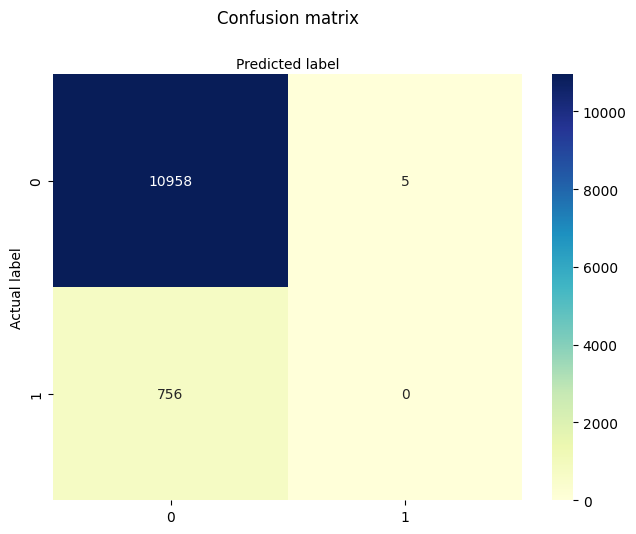

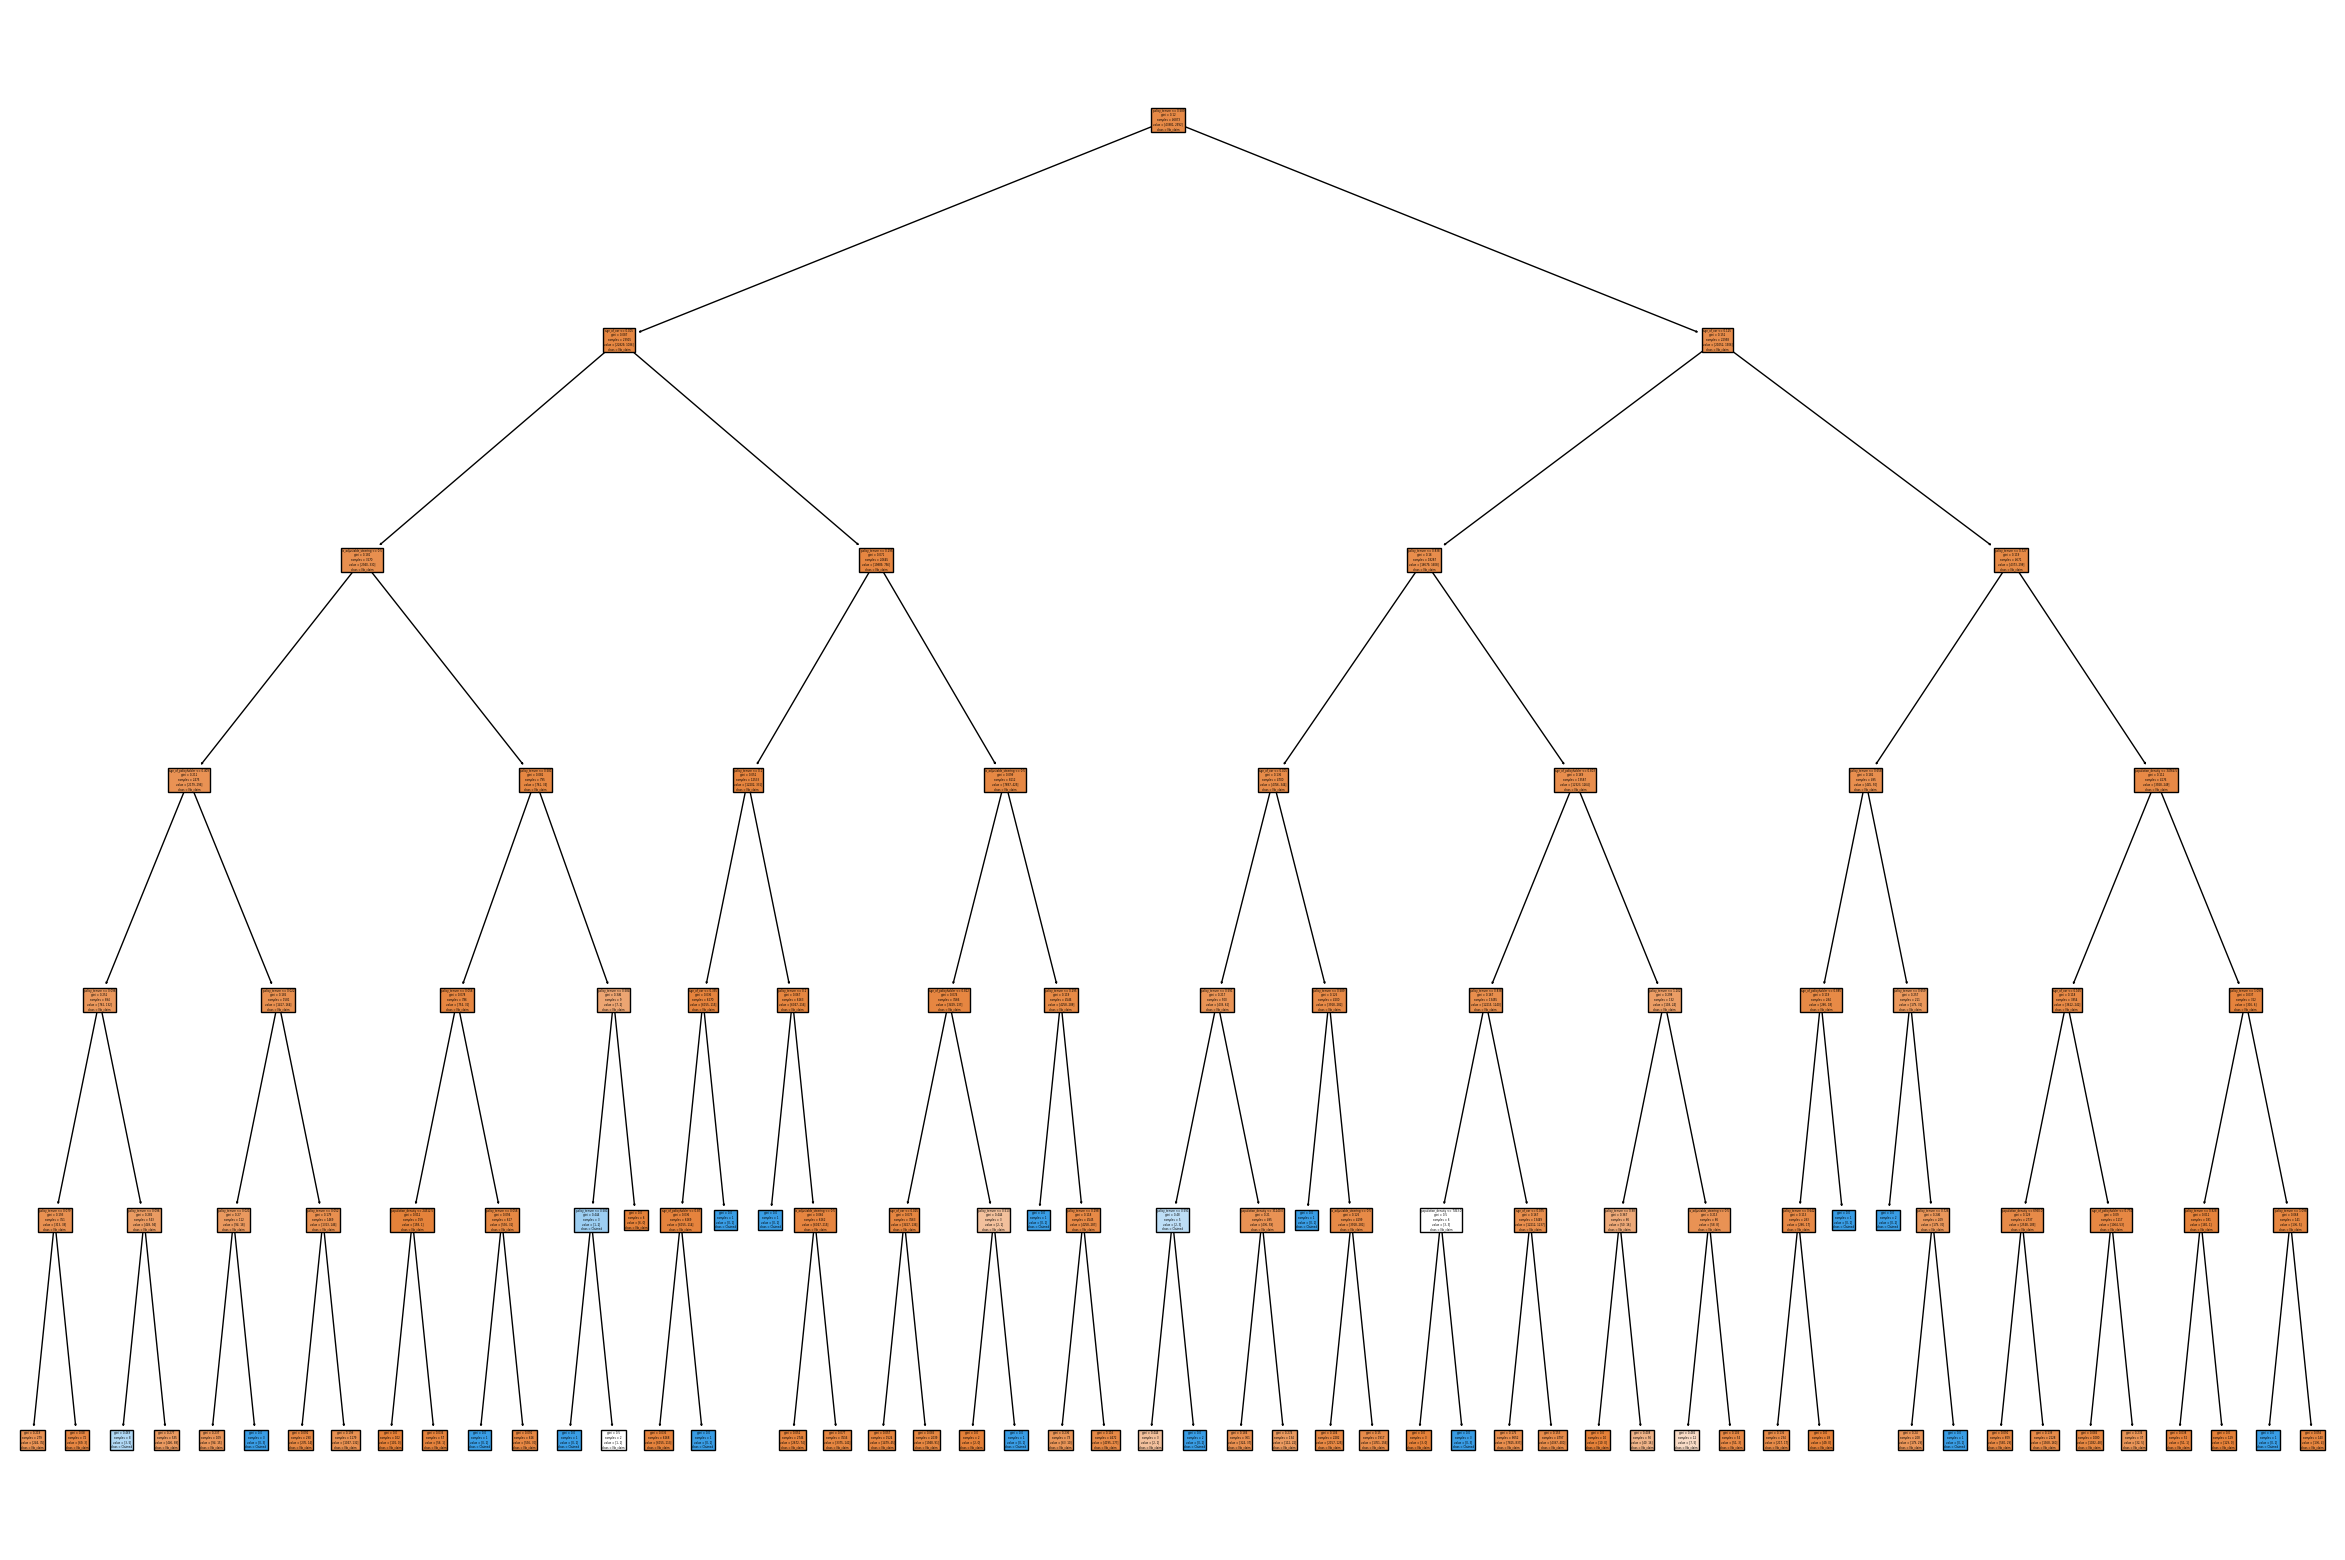

              precision    recall  f1-score   support

    No_claim       0.94      1.00      0.97     10963
     Claimed       0.00      0.00      0.00       756

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.90     11719



In [28]:
# Decision Tree classification model

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

#split dataset in features and target variable

X = data[['policy_tenure','age_of_car','age_of_policyholder','population_density','is_adjustable_steering']]# Features
y = data.is_claim # Target variable
features = X.columns

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=6, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['No_claim','Claimed'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['No_claim','Claimed']
print(classification_report(y_test, y_pred, target_names=target_names))

In [29]:
from sklearn.model_selection import GridSearchCV

# Create the decision tree model
model = DecisionTreeClassifier(random_state=42)
# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': range(1, 21)
}

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1')

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best average F1 score: {grid_search.best_score_:}')

Best hyperparameters: {'max_depth': 20}
Best average F1 score: 0.05157428846671963


### Decision Tree with oversampling

pip install -U imbalanced-learn

In [30]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE()

# Fit and transform the data
X_oversampled, y_oversampled = smote.fit_resample(X, y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2, random_state= 42)

# Create and fit the decision tree model
model = DecisionTreeClassifier(random_state=42)
scores_f1 = cross_val_score(model, X_train, y_train, scoring="f1", cv=10)
scores_f1.mean()

0.9132859179052126

Accuracy: 0.6543440605342329
Recall: 0.6561751831811975


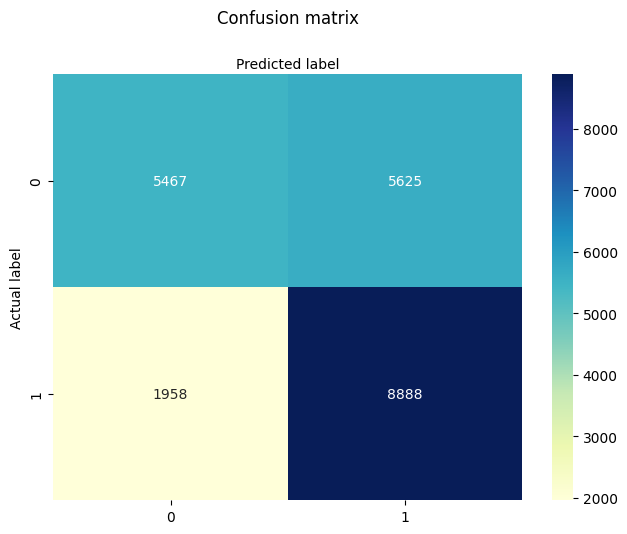

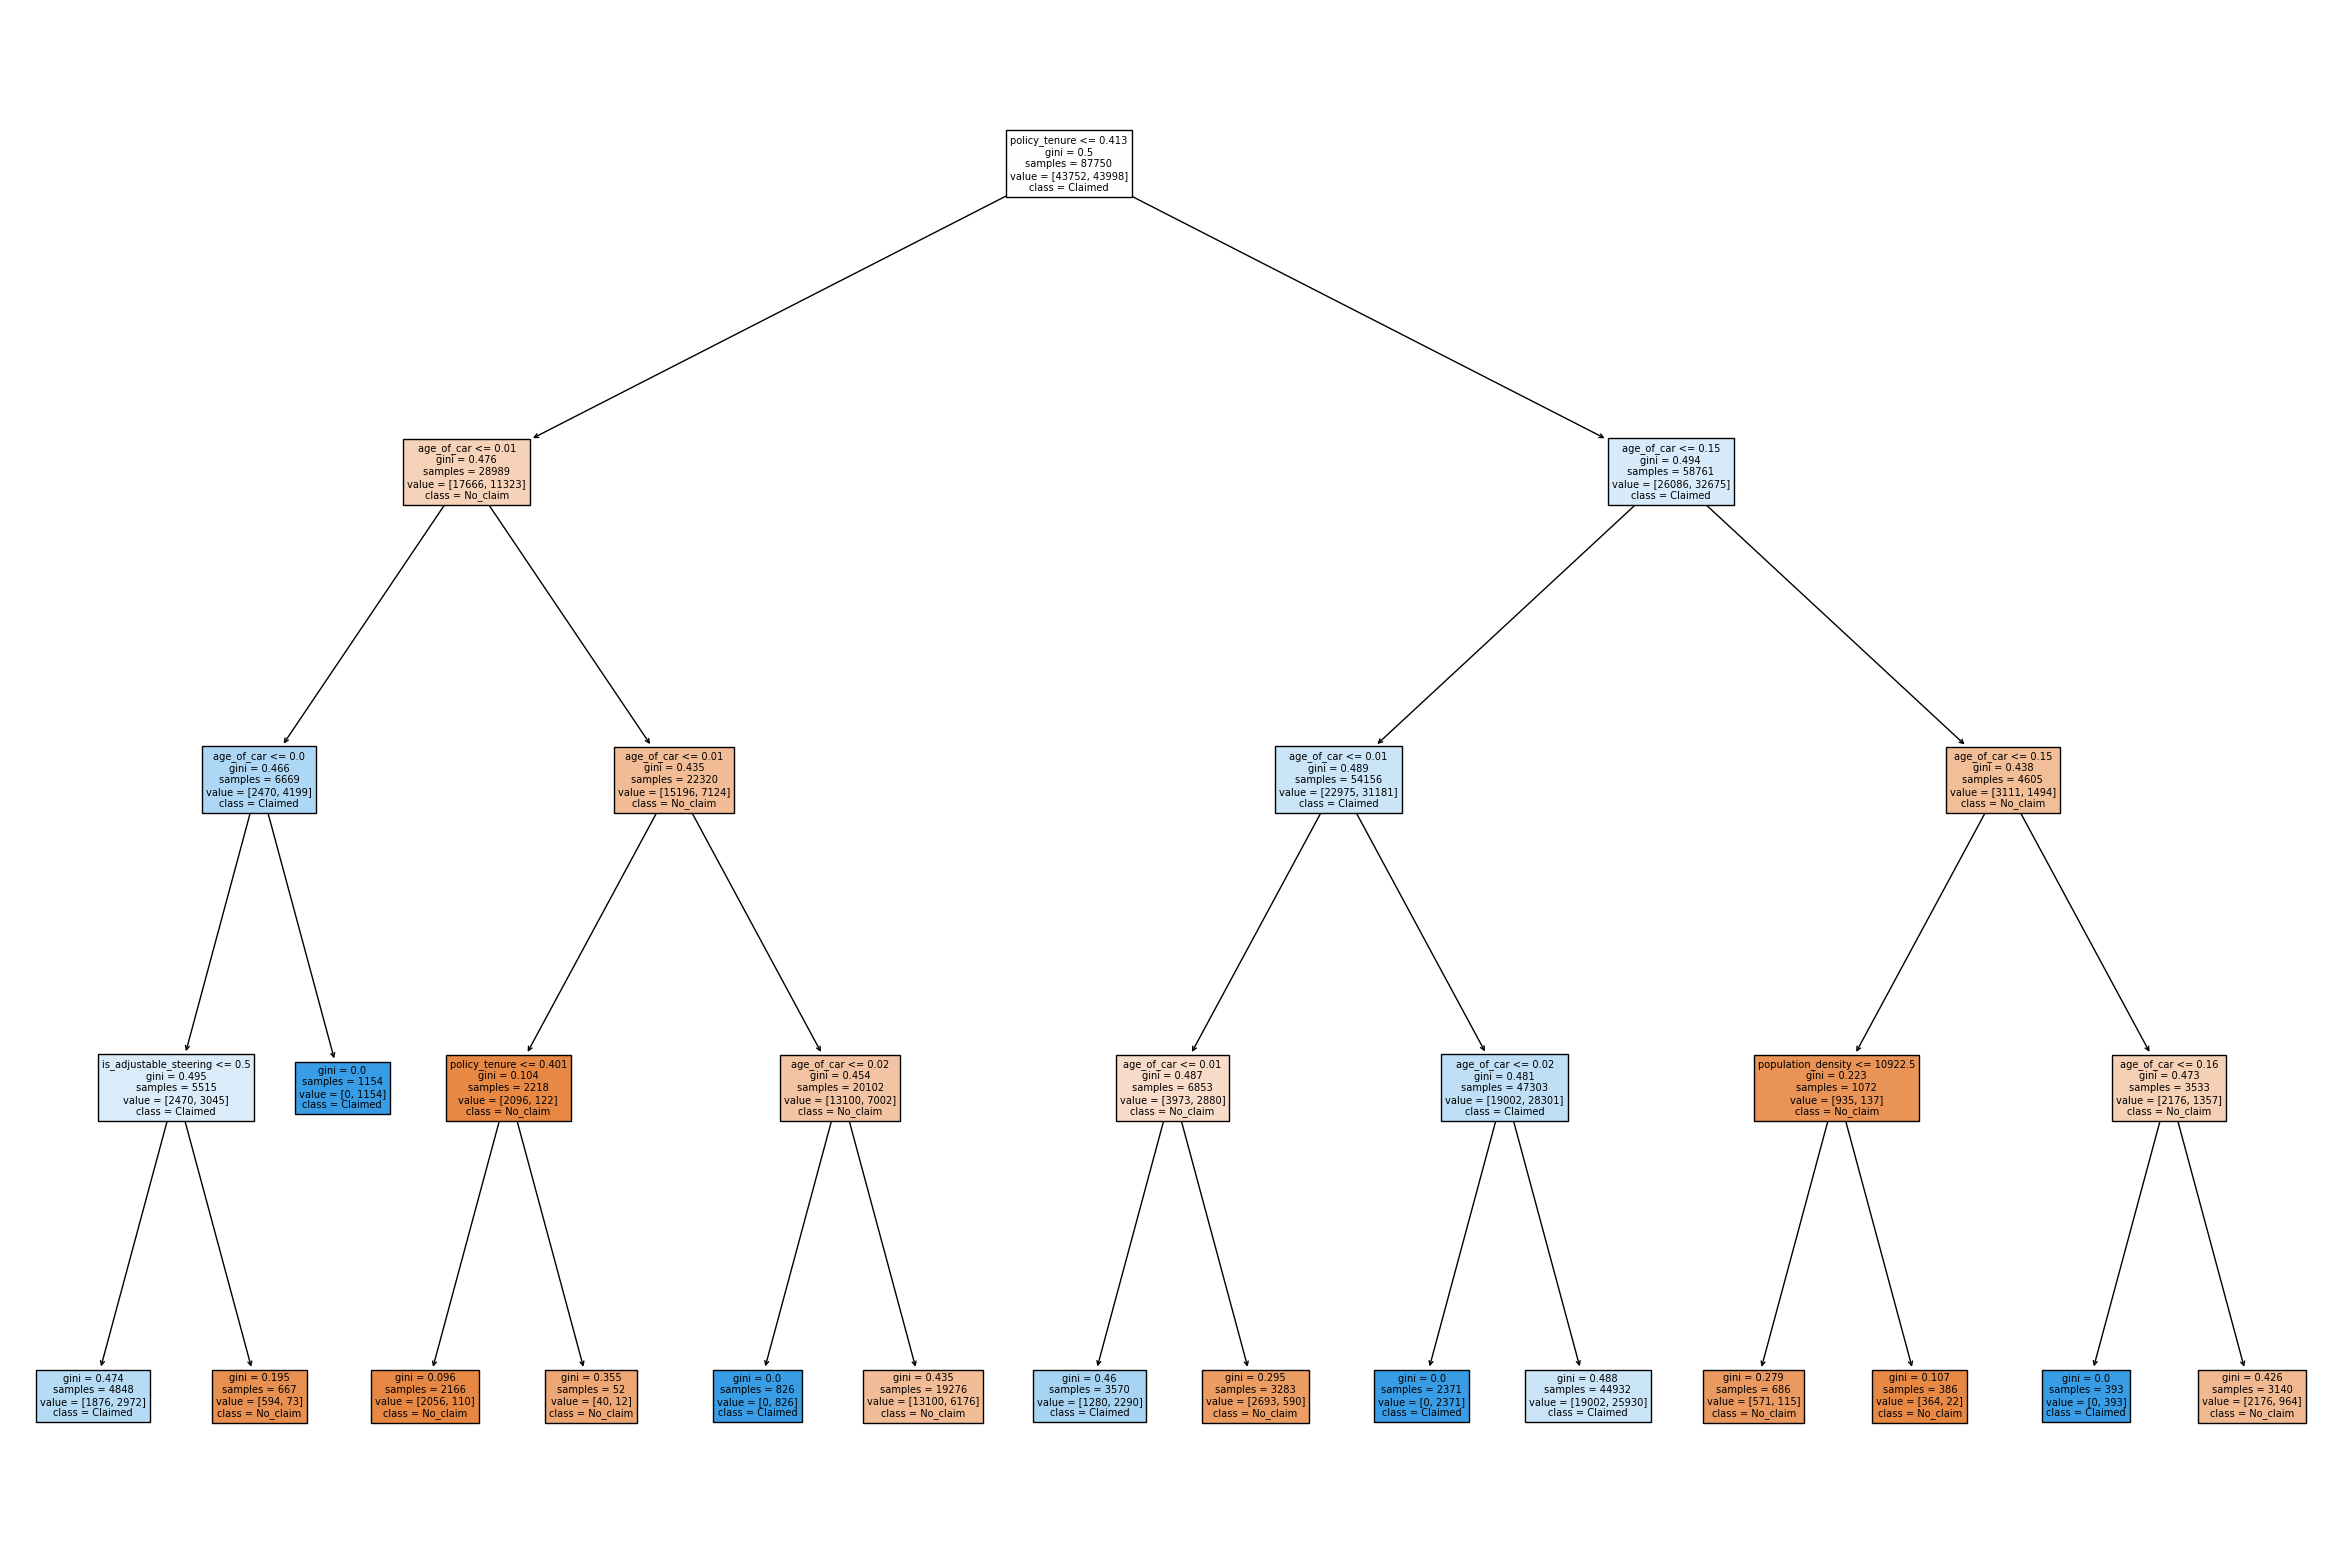

              precision    recall  f1-score   support

    No_claim       0.74      0.49      0.59     11092
     Claimed       0.61      0.82      0.70     10846

    accuracy                           0.65     21938
   macro avg       0.67      0.66      0.65     21938
weighted avg       0.68      0.65      0.65     21938



In [33]:
# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['No_claim','Claimed'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['No_claim','Claimed']
print(classification_report(y_test, y_pred, target_names=target_names))

### Question

Results of the decision tree model show that the model is not capturing the data well enough. However, after doing oversampling, the model performs better classifying the target variable. Is this process beneficial for the model or is it just creating noise and an illusion of a good perfoming model?